In [1]:
# SGDClassifier again but with even more features removed
# All that's left are Age, Sex, Pclass, and Embarked

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import joblib

In [2]:
train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")

In [3]:
# only 2 values are null, so it's not worth using an imputer
train_set.dropna(subset=["Embarked"], inplace=True)
nec_data = train_set.copy()

# making y_train
nec_data = nec_data.drop("Survived", axis=1)
survived = pd.DataFrame(train_set["Survived"].copy())

# Anything individual, not categorial, is irrelevant
nec_data = nec_data.drop("Name", axis=1)
nec_data = nec_data.drop("PassengerId", axis=1)
nec_data = nec_data.drop("Ticket", axis=1)
# too many null values
nec_data = nec_data.drop("Cabin", axis=1)
# no real relations to be found in either of these imo
nec_data = nec_data.drop("SibSp", axis=1)
nec_data = nec_data.drop("Parch", axis=1)
# too individual, and socioeconomic stuff is already covered via Pclass
nec_data = nec_data.drop("Fare", axis=1)

[]

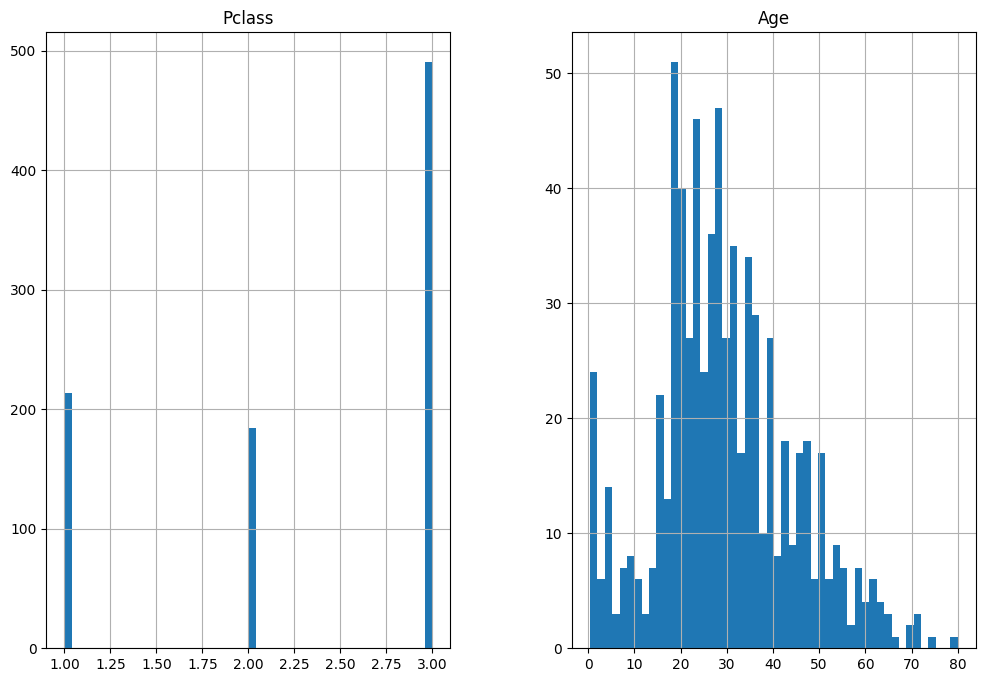

In [4]:
nec_num = nec_data.select_dtypes(include=[np.number])
nec_num.hist(bins=50, figsize=(12, 8))
plt.plot()

In [6]:
text_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))
num_norm_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
preprocess = ColumnTransformer([
    ("text", text_pipeline, make_column_selector(dtype_include=object))],
    remainder=num_norm_pipeline
)

In [9]:
sgd_clf = Pipeline([("pre", preprocess), ("clf", SGDClassifier(loss='hinge', learning_rate="optimal", random_state=446))])
survived = np.array(survived).ravel()
sgd_clf.fit(nec_data, survived)
print(sgd_clf.predict(nec_data[:10]))
print(survived[:10])

[0 1 1 1 0 0 0 1 1 1]
[0 1 1 1 0 0 0 0 1 1]


In [19]:
randarr = np.zeros(10)
for k in range(len(randarr)):
    randarr[k] = random.uniform(0.185, 0.225)
print(randarr)
param_distribs = {"clf__alpha": randarr}
rmd_search = RandomizedSearchCV(
    sgd_clf, param_distributions=param_distribs, n_iter=10, cv=3, scoring="neg_root_mean_squared_error", random_state=446
)

rmd_search.fit(nec_data, survived)

[0.19768161 0.223229   0.20750424 0.18621404 0.22219098 0.21091121
 0.22383438 0.18761509 0.19681208 0.20820416]


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pre',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('text',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x00000216426EC7C0>)])),
                                             ('clf',
                                              SGDClassifier(random_state=446))]),
                   param_distributions={'clf__alpha': array([0.19768161, 0.223229  , 0.20750424, 0.18621404, 0.22219098,
       0.21091121, 0.22383438, 0.18761509, 0.19681208, 0.20820416])},
                   random_state=446, scoring='neg_root_mean_squared_error')

In [20]:
final_model = rmd_search.best_estimator_
print(final_model.get_params)

<bound method Pipeline.get_params of Pipeline(steps=[('pre',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('text',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000216470F28C0>)])),
            

In [22]:
rmse = -cross_val_score(final_model, nec_data, survived, scoring="neg_root_mean_squared_error", cv=8)
print(rmse)

[0.4330127  0.474579   0.42447636 0.44519456 0.474579   0.51113722
 0.474579   0.46499055]


In [23]:
# ids2 = np.array(test_set["PassengerId"].copy()).ravel()
# test_pred = final_model.predict(test_set)
# with open('sacreddeer_titanic_submission_3.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(["PassengerId", "Survived"])
#     for k in range(len(ids2)):
#         writer.writerow([ids2[k], test_pred[k]])

In [29]:
# with open('autograde_test.csv', 'w') as f2:
#     writer = csv.writer(f2)
#     writer.writerow(["PassengerId", "Survived"])
#     for k in range(len(ids2)):
#         writer.writerow([ids2[k], 0])